# Chunking (Big Data) Files in Python

Chunking:  
To break your files into smaller more manageable units (or chunks) that are processed individually

Benifits:
1. You can make use of multiple processors.
2. You can avoid memory overflow

Big data:  
A term for data sets that are so large or complex that traditional data processing applications are inadequate.

For me:   
- Ribo-seq files ~100GB. 
- Processing 50+ 

For Malte:
- Anything that doesn't fit in his RAM

##Set-up

###The task at hand

Count the number of "A"s in a text document

In [1]:
def process(line):
    return line.count("A")

###Data!

In [2]:
import os
fname = "data/input.fa"
if not os.path.exists(fname):
    !curl -o "data/input.fa.gz" ftp://ftp.ensembl.org/pub/release-85/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
    !gzip -d "input.fa.gz"
os.path.getsize(fname)

338864169

(That's 323M)

##How to read a file

###Attempt 1

In [3]:
import time

t = time.time()
with open(fname) as f:
    data = f.readlines()
    count = 0
    for line in data:
        count += process(line)
print count
print time.time() - t

74482847
4.07568407059


###Attempt 2

In [4]:
with open(fname) as f:
    count = 0
    for line in f: 
        count += process(line)
print count

74482847


##How to read a file using multiple processors

###Attempt 1

In [5]:
import multiprocessing as mp

cores = 4
if 0:
    pool = mp.Pool(cores)
    jobs = []
    count = 0

    #create jobs
    with open(fname) as f:
        for line in f:
            jobs.append( pool.apply_async(process,(line,)) )

    #wait for all jobs to finish
    for job in jobs:
        count += job.get()

    print count
    pool.close()

###Attempt 2

In [6]:
def process_wrapper(lineID):
    with open(fname) as f:
        for i,line in enumerate(f):
            if i == lineID:
                return process(line)

In [7]:
if 0:
    pool = mp.Pool(cores)
    jobs = []
    count = 0

    with open(fname) as f:
        for lineID,line in enumerate(f):
            jobs.append( pool.apply_async(process_wrapper,(lineID,)) )

    for job in jobs:
        count += job.get()
        
    print count
    pool.close()

###Attempt 3

In [8]:
def process_wrapper(lineByte):
    with open(fname) as f:
        f.seek(lineByte)
        line = f.readline()
        return process(line)

In [9]:
if 0:
    pool = mp.Pool(cores)
    jobs = []
    count = 0

    with open(fname) as f:
        lineByte = f.tell()
        for line in iter(f.readline, ''):
            jobs.append( pool.apply_async(process_wrapper,(lineByte,)) )
            lineByte = f.tell()

    for job in jobs:
        count += job.get()

    print count
    pool.close()

##Let's get chunky

In [10]:
import timeit
print timeit.timeit('f=open("data/input.fa");sum([l.count("A") for l in f])',number=10)
print timeit.timeit('f=open("data/input.fa");sum([c.count("A") for c in iter(lambda: f.read(1024*1024),"")])',number=10)

26.3747119904
10.1480989456


In [11]:
def chunkify(fname,size=1024*1024):
    fileEnd = os.path.getsize(fname)
    with open(fname,'r') as f:
        chunkEnd = f.tell()
        while True:
            chunkStart = chunkEnd
            f.seek(size,1)
            f.readline() #finish line
            chunkEnd = f.tell()
            yield chunkStart, chunkEnd - chunkStart
            if chunkEnd > fileEnd:
                break

def process_wrapper(fname,chunkStart, chunkSize):
    with open(fname) as f:
        f.seek(chunkStart)
        lines = f.read(chunkSize).splitlines()
        count = 0
        for line in lines:
            count += process(line)
        return count

In [12]:
t = time.time()
pool = mp.Pool(cores)
jobs = []
count = 0

#create jobs
for chunkStart,chunkSize in chunkify(fname):
    jobs.append( pool.apply_async(process_wrapper,(fname,chunkStart,chunkSize)) )

#wait for all jobs to finish
for job in jobs:
    count += job.get()

#clean up
pool.close()
print count
print time.time() - t

74482847
1.73516106606


##A more pratical example

###The task at hand

Get the lengths of each sequence in a Fasta file

An example fasta file:
```
>SEQUENCE_1
MTEITAAMVKELRESTGAGMMDCKNALSETNGDFDKAVQLLREKGLGKAAKKADRLAAEG
LVSVKVSDDFTIAAMRPSYLSYEDLDMTFVENEYKALVAELEKENEERRRLKDPNKPEHK
IPQFASRKQLSDAILKEAEEKIKEELKAQGKPEKIWDNIIPGKMNSFIADNSQLDSKLTL
MGQFYVMDDKKTVEQVIAEKEKEFGGKIKIVEFICFEVGEGLEKKTEDFAAEVAAQL
>SEQUENCE_2
SATVSEINSETDFVAKNDQFIALTKDTTAHIQSNSLQSVEELHSSTINGVKFEEYLKSQI
ATIGENLVVRRFATLKAGANGVVNGYIHTNGRVGVVIAAACDSAEVASKSRDLLRQICMH
```

In [13]:
def chunkify(fname,size=1024*1024):
    fileEnd = os.path.getsize(fname)
    with open(fname,'r') as f:
        chunkEnd = f.tell()
        while True:
            chunkStart = chunkEnd
            f.seek(size,1)
            l = f.readline() #incomplete line
            p = f.tell()
            l = f.readline()
            while l and l[0] != '>': #find the start of sequence
                p = f.tell()
                l = f.readline()
            f.seek(p) #revert one line
            
            chunkEnd = f.tell()
            yield chunkStart, chunkEnd - chunkStart
            if chunkEnd > fileEnd:
                break

In [14]:
def process(fname,chunkStart,chunkSize):
    with open(fname) as f:
        f.seek(chunkStart)
        lines = f.read(chunkSize).splitlines()
        counts = []
        count = 0
        for line in lines[1:]:
            if line[0] == '>':
                counts.append(count)
                count = 0
            else:
                count += len(line)
        counts.append(count)
        return counts

In [15]:
#init objects
pool = mp.Pool(cores)
jobs = []
counts = []

#create jobs
for chunkStart,chunkSize in chunkify(fname):
    jobs.append( pool.apply_async(process,(fname,chunkStart,chunkSize)) )

#wait for all jobs to finish
for job in jobs:
    counts += job.get()

counts
pool.close()

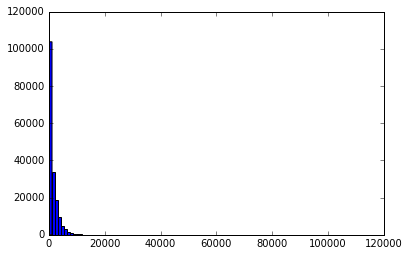

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(counts,100)
plt.show()